# Employment rates and Income

## Introduction

The goal of the project is to import two datasets from Statistics Denmark reporting employment rates and income levels. From the unemployment data we will extract two different employmentrates that resemple the employment of decendants of Non-western immigrants and the total poluation in Denmark in the period 2008-2018. Further we import an income statistic fromwhere we extract a serie of disposable income for the educational level vocational.

The data will be cleaned out for municipalities, so we can present and compare the data on regional level. This enables us to merge the datasets into one set from where we can contruct interactive charts. 

Lastly we compute a new variable, which represent the deviation of unemployment from the mean.

In [1]:
# Importing the packages we need for the project
import numpy as np
import pandas as pd
import datetime

import pandas_datareader
import pydst 


import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Import data from Denmark Statistics


In [26]:
dst = pydst.Dst(lang='en')
dst.get_subjects()

tables = dst.get_tables(subjects=['04'])
tables[tables.id == 'INDKP107']
indk_vars = dst.get_variables(table_id='INDKP107')

In [27]:
# #We look at the data to see how we can sort it. 
indk_vars = dst.get_variables(table_id='INDKP107')
for id in ['ENHED','KOEN','UDDNIV','INDKOMSTTYPE']:
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

ENHED
 id = 101, text = People with type of income (number)
 id = 110, text = Amount of income (DKK 1.000)
 id = 116, text = Average income for all people (DKK)
 id = 121, text = Average income for people with type of income (DKK)
KOEN
 id = MOK, text = Men and women, total
 id = M, text = Men
 id = K, text = Women
UDDNIV
 id = 10, text = 10 BASIC SCHOOL 8-10 grade
 id = 26, text = 20+25 UPPER SECONDARY SCHOOL
 id = 35, text = 35 VOCATIONAL EDUCATION
 id = 40, text = 40 SHORT-CYCLE HIGHER EDUCATION
 id = 61, text = 50+60 MEDIUM-CYCLE HIGHER EDUCATION, BACHLEOR
 id = 65, text = 65 LONG-CYCLE HIGHER EDUCATION
 id = 9, text = Not stated
INDKOMSTTYPE
 id = 100, text = 1 Disposable income (2+30-31-32-35)
 id = 105, text = 2 Pre-tax Income, total (3+7+22+26+29)
 id = 110, text = 3 Primary income (4+5+6)
 id = 115, text = 4 Wages and salaries etc., total
 id = 120, text = 5 Entrepreneurial income, total
 id = 125, text = 6 Received fees subject to labour market contributions
 id = 130, text =

In [28]:
#For each year and area, we choose to look at average disposable income for people with vocational education.
inc = dst.get_data(table_id = 'INDKP107', variables= {'OMRÅDE':['*'], 'TID':['*'], 'UDDNIV':['35'],  'ENHED':['116'], 'INDKOMSTTYPE':['100']})

#... and we look at the employment rate for each year, area, and origin.
empl = dst.get_data(table_id = 'RAS200', variables={'OMRÅDE':['*'], 'TID':['*'], 'HERKOMST':['*']})

In [7]:
empl.head()


,OMRÅDE,TID,HERKOMST,ALDER,KØN,BEREGNING,INDHOLD
0,Hørsholm,2008,Descendants from non-western countries,"Age, total",Total,Employment rate,56.9
1,Hørsholm,2009,Descendants from non-western countries,"Age, total",Total,Employment rate,53.3
2,Hørsholm,2010,Descendants from non-western countries,"Age, total",Total,Employment rate,57.1
3,Høje-Taastrup,2011,Descendants,"Age, total",Total,Employment rate,55.7
4,Høje-Taastrup,2012,Descendants,"Age, total",Total,Employment rate,54.4


In [8]:
inc.head() 

,OMRÅDE,TID,UDDNIV,ENHED,INDKOMSTTYPE,KOEN,INDHOLD
0,Fanø,2013,35 VOCATIONAL EDUCATION,Average income for all people (DKK),1 Disposable income (2+30-31-32-35),"Men and women, total",225466
1,Varde,2013,35 VOCATIONAL EDUCATION,Average income for all people (DKK),1 Disposable income (2+30-31-32-35),"Men and women, total",235711
2,Vejen,2013,35 VOCATIONAL EDUCATION,Average income for all people (DKK),1 Disposable income (2+30-31-32-35),"Men and women, total",226659
3,Aabenraa,2013,35 VOCATIONAL EDUCATION,Average income for all people (DKK),1 Disposable income (2+30-31-32-35),"Men and women, total",215493
4,Fredericia,2013,35 VOCATIONAL EDUCATION,Average income for all people (DKK),1 Disposable income (2+30-31-32-35),"Men and women, total",218775


In [29]:
#Renaming 
columns_dict_empl = {}
columns_dict_empl['OMRÅDE'] = 'area'
columns_dict_empl['TID'] = 'year'
columns_dict_empl['HERKOMST'] = 'origin'
columns_dict_empl['INDHOLD'] = 'emp'

columns_dict_inc = {}
columns_dict_inc['OMRÅDE'] = 'area'
columns_dict_inc['TID'] = 'year'
columns_dict_inc['INDHOLD'] = 'income'
columns_dict_inc['UDDNIV'] = 'educ'

empl.rename(columns=columns_dict_empl,inplace=True)
inc.rename(columns=columns_dict_inc,inplace=True)

##Disposable income by region
I = inc.area.str.contains('Region')
inc =  inc.loc[I,['area','year','income']]
inc.head(10)

#Employment rate total by region
I = empl.area.str.contains('Region')
empl=  empl.loc[I,['area','year','origin','emp']]
empl_copy =empl



In [30]:
#From this data we pick out two different employment rates. This is performed in three steps:

#Step 1: Get the total employment rate
I= empl.origin.str.contains('Total')
empl=  empl.loc[I,['area','year','emp']]

#Step 2: From the copy of empl we make the employment rate for decendents of non-western immigrants.
L = empl_copy.origin.str.contains('Descendants from non-western countries')
empl_copy=  empl_copy.loc[L,['area','year','emp']]
empl_copy.rename(columns ={'emp':'emp_nw'}, inplace=True)

#Step 3 Merge the two sets and obtain the final employment dataset: empl_true
empl_true = pd.merge(empl, empl_copy, on=['area','year'], how='left')

In [31]:
#Plotting the employment dataset:
empl_true.head()

,area,year,emp,emp_nw
0,Region Midtjylland,2011,72.4,50.0
1,Region Midtjylland,2012,71.8,47.5
2,Region Midtjylland,2013,71.7,47.2
3,Region Midtjylland,2014,72.2,49.3
4,Region Nordjylland,2011,71.0,44.1


## Merging and arriving at the final dataset

In [12]:
#Finally merge the income data set to the employment data.

#Looking into the data, which differs interms of range of years
print(f'Years in empl_true: {empl_true.year.unique()}')
print(f'Years in inc: {inc.year.unique()}')

#Finding the differences
diff_y = [y for y in inc.year.unique() if y not in empl_true.year.unique()] 
print(f'years in income data, but not in the employment data: {diff_y}')

#Merging
data = pd.merge(empl_true, inc, on=['area','year'], how='left')
data_true = data.sort_values(['area','year'])

Years in empl_true: [2011 2012 2013 2014 2008 2009 2010 2015 2016 2017 2018]
Years in inc: [2013 2012 2011 2010 2009 2008 2006 2005 2004 2014 2015 2007 2016 2017
 2018]
years in income data, but not in the employment data: [2006, 2005, 2004, 2007]


In [13]:
# Creating a new variable: Mean of disposable income for each region across years .

inc_mean = data_true.groupby('area')['income'].apply(lambda x: x.mean()).head() 
inc_mean.head(10)
inc_mean.name = 'inc_mean' # necessary for join
inc_mean.head(10)

area
Region Hovedstaden    228339.636364
Region Midtjylland    224758.909091
Region Nordjylland    215044.545455
Region Sjælland       222744.818182
Region Syddanmark     215945.181818
Name: inc_mean, dtype: float64

In [14]:
#Mergin the new variable to the dataset
data_true = pd.merge(data_true, inc_mean, on=['area'], how='left')


In [15]:
#Creating a new variable: The difference of the recorded income to the mean.
data_true['diff_to_mean']= data_true['income']-data_true['inc_mean']

In [16]:
#The final dataset
data_true.head(50)

,area,year,emp,emp_nw,income,inc_mean,diff_to_mean
0,Region Hovedstaden,2008,75.8,65.7,197692,228339.636364,-30647.636364
1,Region Hovedstaden,2009,73.3,59.7,198466,228339.636364,-29873.636364
2,Region Hovedstaden,2010,72.6,57.3,214620,228339.636364,-13719.636364
3,Region Hovedstaden,2011,72.5,56.2,219615,228339.636364,-8724.636364
4,Region Hovedstaden,2012,72.2,55.0,224140,228339.636364,-4199.636364
5,Region Hovedstaden,2013,72.3,55.5,229318,228339.636364,978.363636
6,Region Hovedstaden,2014,72.5,55.6,235023,228339.636364,6683.363636
7,Region Hovedstaden,2015,73.2,57.7,241364,228339.636364,13024.363636
8,Region Hovedstaden,2016,73.8,58.7,244771,228339.636364,16431.363636
9,Region Hovedstaden,2017,74.4,60.5,250257,228339.636364,21917.363636


## Descriptive statistics

In [17]:
#Plain desriptive statistics
data_true.describe()
#Mean
print(" The mean employment rate of the total population by region")
data_true.groupby('area')['emp'].apply(lambda x: x.mean()).head()


 The mean employment rate of the total population by region


area
Region Hovedstaden    73.445455
Region Midtjylland    73.290909
Region Nordjylland    71.636364
Region Sjælland       72.481818
Region Syddanmark     71.700000
Name: emp, dtype: float64

In [18]:
print("The mean employmentrate of descendants of non-western immigrants")
data_true.groupby('area')['emp_nw'].apply(lambda x: x.mean()).head()

The mean employmentrate of descendants of non-western immigrants


area
Region Hovedstaden    58.627273
Region Midtjylland    52.190909
Region Nordjylland    45.209091
Region Sjælland       56.000000
Region Syddanmark     50.136364
Name: emp_nw, dtype: float64

# Plotting both employment rates for the regions

In [19]:
import ipywidgets as widgets
def plot_data_true(df, area): 
    I = df['area'] == area
    ax=df.loc[I,:].plot(x='year', y={'emp_nw','emp'}, style='-o', legend=False)

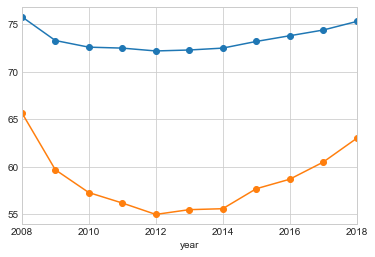

In [20]:
widgets.interact(plot_data_true, 
    df = widgets.fixed(data_true),
    area = widgets.Dropdown(description='area', 
                                    options=data.area.unique(), 
                                    value='Region Hovedstaden')
); 

# Plotting the disposable income of the regions over years.

In [21]:
#Plotting income. 
import ipywidgets as widgets
def plot_data_true(df, area): 
    I = df['area'] == area
    ax=df.loc[I,:].plot(x='year', y='income', style='-o', legend=False)

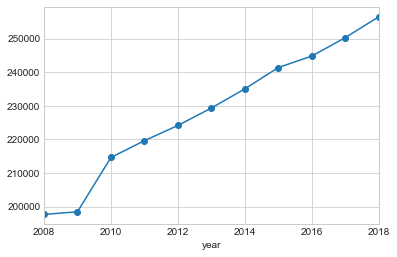

In [22]:
widgets.interact(plot_data_true, 
    df = widgets.fixed(data_true),
    area = widgets.Dropdown(description='area', 
                                    options=data.area.unique(), 
                                    value='Region Hovedstaden')
); 

# Plotting the difference to the mean for income

In [23]:
#Plotting income. 
import ipywidgets as widgets
def plot_data_true(df, area): 
    I = df['area'] == area
    ax=df.loc[I,:].plot(x='year', y='diff_to_mean', style='-o', legend=False)

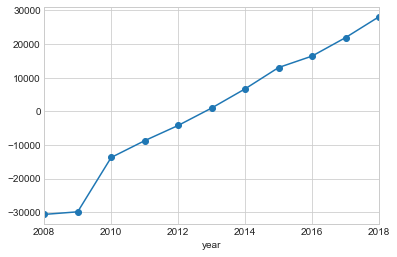

In [24]:
widgets.interact(plot_data_true, 
    df = widgets.fixed(data_true),
    area = widgets.Dropdown(description='area', 
                                    options=data.area.unique(), 
                                    value='Region Hovedstaden')
); 

## Conclusion

We have looked into the employmentrates of descendants of non-western immigrants and the total population in Denmark at a regional level. From this we have seen that the employmentrate of the decendants is lower for all regions across the whole period 2008-2018. From the graph it seems that the decendants were impacted more by the financial crisis than the total employment rate, as the employment rate of the descendants fell more. 

From the income variabel we can see that the disposable income have been increasing across the timeperiod. It seems not to be affected by the financial crisis in 2012 were the employment rates fell.